The upgrades to DarkHistory account for a number of new effects:
1.  $\bf{DM\to \Delta f_\gamma}$. DM energy injection produces low energy photons that contribute to the blackbody distortion.
2.  $\bf{f_{exc,nl}\to \Delta f_\gamma}$. Some of that energy excites hydrogen atoms to the $nl$ excited state. These atoms then transition through many other excited states, producing or absorbing line photons that contribute to the distortion.
3.  $\bf{f_{exc,nl}\to \dot{x}_e}$. Sometimes these excited state transitions end in an ionization.
{4.  $\bf{f_{ion}\to \Delta f_\gamma}$. Extra ionization means extra photon absorption, and also an increase in recombinations, both of which affect the distortion.}
5. $\bf{\Delta f_\gamma \to \dot{x}_e}$. All rates -- recombination, ionization, and atomic transitions -- depend on the photon phase space density.  When $\Delta f_\gamma$ is non-zero, the rates change, and the ionization rate changes.
6. $\bf{\Delta f_\gamma \to \Delta f_\gamma}$. The distortion can be reprocessed over time, e.g. photons that are emitted at early times can be absorbed at later times.

In [2]:
import sys
sys.path.append('../..')

import config
import main
import pickle

import numpy as np
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d, interp2d

import darkhistory.physics as phys
from darkhistory.spec.spectra import Spectra
from darkhistory.spec.spectrum import Spectrum
import darkhistory.low_energy.atomic as atomic
import darkhistory.spec.spectools as spectools

from plotting_utils import plot_distortion, download_plot

from scipy.interpolate import interp2d

In [3]:
input_dir = '/Users/gregoryridgway/Dropbox (MIT)/DarkHistory_V2/data/'

n10_data = download_plot('n10', input_dir)
n20_data = download_plot('n20', input_dir)
n30_data = download_plot('n30', input_dir)
jens_data = download_plot('Full_Distortion', input_dir)
jens_2s = download_plot('DeltaR_2s_jens', input_dir)
jens_2p = download_plot('DeltaR_2p_jens', input_dir)
BB_BF_jens = download_plot('BB_plus_BF_dist', input_dir)

In [4]:
input_dir = config.data_path

decay_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])

f_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_swave.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1]

f_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_swave.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1]

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

decay_elec_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])

#Derived from Planck 2018 cosmological parameters
p_ann = 3.5e-28

def param_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]

def param_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]
    
def param_bound(mDM, DM_process, pri):
    if pri == 'elec':
        return param_bound_elec_CMB(mDM, DM_process)
    else:
        return param_bound_phot_CMB(mDM, DM_process)

In [5]:
fig_dir = '/Users/gregoryridgway/Dropbox (MIT)/DarkHistory_V2/Drafts/figs/'
savefig=False

In [10]:
# Parameters

nmax = 10
start_rs, high_rs, end_rs = 3e3, 1.555e3, 900
cf = 16
rtol = 1e-6

# DM model
pri, DM_process = 'elec', 'decay'
mDM = 2e8

if DM_process == 'swave':
    struct_boost_func = phys.struct_boost_func()
    
param = param_bound(mDM, DM_process, pri)

# Full Distortion

In [17]:
# We use the iterative method.
# First solve the evolution equations assuming Recfast's
# alpha_B and beta_B rates (e.g. by setting recfast_TLA = True).
# One output is the a new set of rates
iter0 = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param, sigmav=param,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs=high_rs, end_rs=end_rs,
    reion_switch=True, reion_method='Puchwein', heat_switch=True,
    coarsen_factor=cf,
    distort=True, recfast_TLA=True,
    nmax=nmax, rtol=rtol
)

rates = iter0['MLA']

  0%|          | 0/76.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


In [14]:
MLA_funcs = [interp1d(rates[0], rates[i], fill_value='extrapolate')
             for i in range(1,4)]

full = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param, sigmav=param,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = high_rs, end_rs=end_rs,
    reion_switch=True, reion_method='Puchwein', heat_switch=True,
    coarsen_factor=cf,
    distort=True, recfast_TLA=False, MLA_funcs=MLA_funcs,
    nmax=nmax, rtol=rtol
)

  0%|          | 0/76.0 [00:00<?, ?it/s]

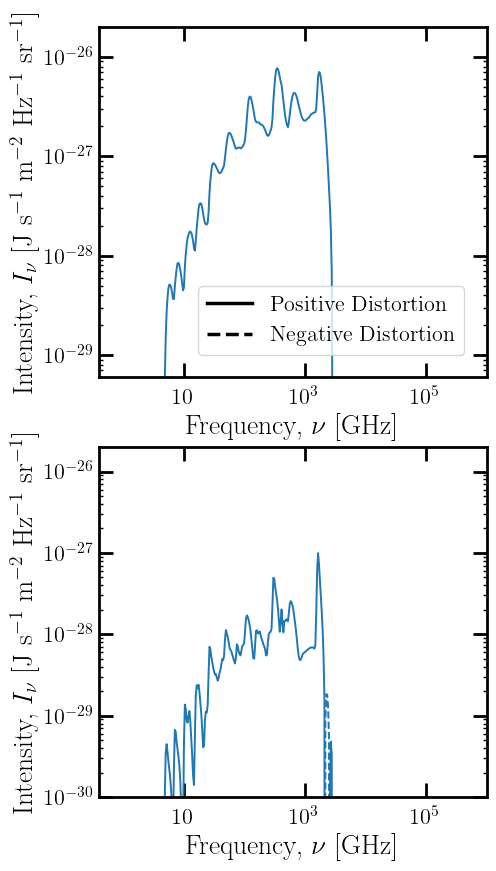

In [25]:
_, axarr = plt.subplots(2,1, figsize=(5,10))
ax = plt.gca()

plot_distortion(axarr[0], full, leg=True)
plot_distortion(axarr[1], full, iter0, diff=True, first=False, ylim=[1e-30,2e-26])

# Separate Distortion Components

In [31]:
# Dictionary that collects all of the separate components of the distortion
components = {}

In [38]:
# ICS component
ICS_component = full['lowengphot'].copy()
ICS_component._grid_vals *= list(map(int, ICS_component.eng < phys.rydberg))
ICS_component.redshift(1)
components['ICS'] = {'distortion': ICS_component.sum_specs()}

In [35]:
# Reionization component
components['reion'] = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=1e40, sigmav=1e-40,
    primary=pri+'_delta',
    start_rs = 30, end_rs=4.01,
    reion_switch=True, reion_method='Puchwein', heat_switch=True,
    coarsen_factor=cf,
    distort=True, recfast_TLA=True,
    nmax=nmax, rtol=rtol
)

  0%|          | 0/126.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7222472758976D+01   r2 = -0.2744981046347D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7107832760464D+01   r2 = -0.1227700241337D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7107832760464D+01   r2 = -0.2455400482675D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7107832760464D+01   r2 = -0.2455400482675D-15
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6667182665143D+01   r2 = -0.8267763920745D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6667182665143D+01   r2 = -0.1878114391657D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6667182665143D+01   r2 = -0.3756228783314D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6667182665143D+01   r2 = -0.3756228783314D-17
 lsoda--  warning..internal t (=r1) 

       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6354717062765D+01   r2 = -0.2990498249972D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6354717062765D+01   r2 = -0.1768716166988D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6354717062765D+01   r2 = -0.1768716166988D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6354717062765D+01   r2 = -0.1768716166988D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5960756375477D+01   r2 = -0.5566887108597D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5960756375477D+01   r2 = -0.1264580229384D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5960756375477D+01   r2 = -0.2529160458767D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5960756375477D+01   r2 = -0.2529160458767D-17
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5591219281182D+01   r2 = -0.4780007941084D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5591219281182D+01   r2 = -0.1085831887853D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5591219281182D+01   r2 = -0.2171663775706D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5591219281182D+01   r2 = -0.2171663775706D-17
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5244591639222D+01   r2 = -0.4042321940308D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5244591639222D+01   r2 = -0.9182583204575D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5244591639222D+01   r2 = -0.1836516640915D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5244591639222D+01   r2 = -0.1836516640915D-17
 lsoda--  warning..internal t (=r1) 

       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4998797490766D+01   r2 = -0.1598371229506D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4998797490766D+01   r2 = -0.9453491686554D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4998797490766D+01   r2 = -0.9453491686554D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4998797490766D+01   r2 = -0.9453491686554D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t +

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4688897037980D+01   r2 = -0.2869591697956D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4688897037980D+01   r2 = -0.6518596222356D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4688897037980D+01   r2 = -0.1303719244471D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4688897037980D+01   r2 = -0.1303719244471D-17
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4398208863910D+01   r2 = -0.2302881575535D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4398208863910D+01   r2 = -0.5231251243690D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4398208863910D+01   r2 = -0.1046250248738D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4398208863910D+01   r2 = -0.1046250248738D-17
 lsoda--  warning..internal t (=r1) 

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4125541903328D+01   r2 = -0.1816698314107D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4125541903328D+01   r2 = -0.4126831972624D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4125541903328D+01   r2 = -0.8253663945248D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4125541903328D+01   r2 = -0.8253663945248D-18
 lsoda--  warning..internal t (=r1) 

Text(0.5, 1.0, 'Distortion Components')

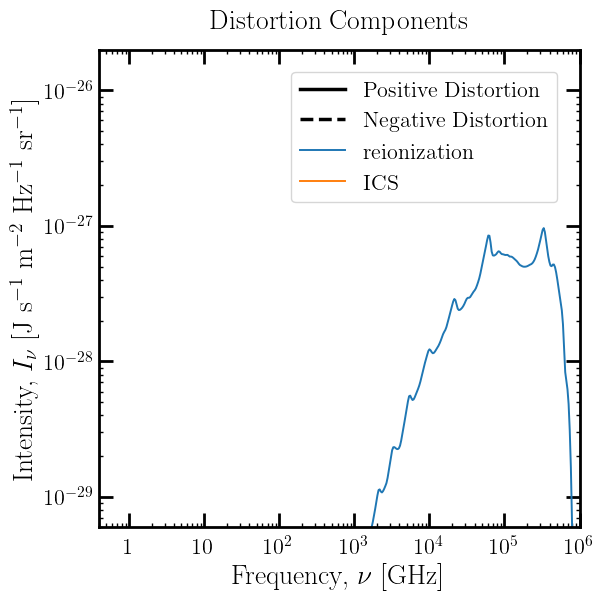

In [46]:
plt.figure()
ax = plt.gca()

plot_distortion(ax, components['reion'], label='reionization', leg=True)
plot_distortion(ax, components['ICS'], label='ICS', leg=True, first=False)
# Should include dipole transitions
# 2s->1s component (quadrupole transition)
# bound-free component
# DM-excitation component (b_DM sourced component)

ax.set_title('Distortion Components', fontsize=20)

# s-wave Structure Formation

In [2144]:
%autoreload

DM_process = 'swave'

no_boost = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param,
    sigmav=param,
    primary=pri+'_delta',
#     struct_boost=phys.struct_boost_func(),
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=cf, rtol=rtol,
    distort=True, recfast_TLA=True,
    fexc_switch = False, 
    reprocess_distortion=False, 
    nmax=nmax,
    reion_switch=False
)

no_boost = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param,
    sigmav=param,
    primary=pri+'_delta',
    struct_boost=phys.struct_boost_func(),
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=cf, rtol=rtol,
    distort=True, recfast_TLA=True,
    fexc_switch = False, 
    reprocess_distortion=False, 
    nmax=nmax,
    reion_switch=False
)

  0%|          | 0/414.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:683: RuntimeWarning: overflow encountered in true_divide
  K[nl, states_l == l+1] = BB['dn'][l+2:, n, l+1]/tot_rate


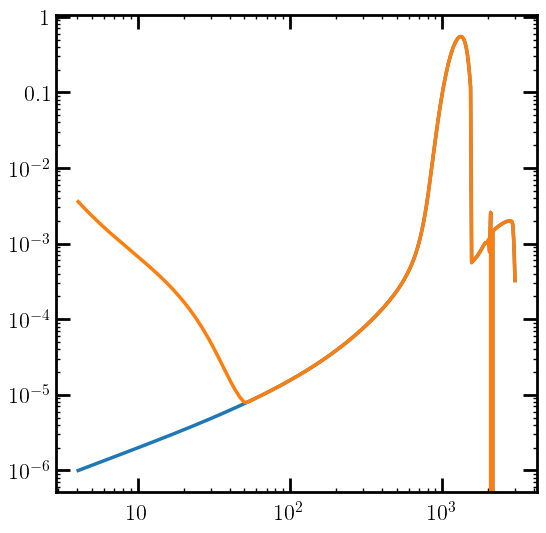

In [2147]:
plt.figure()
plt.loglog()

plt.plot(no_boost['rs'], no_boost['distortions'].toteng())
plt.plot(no_boost['rs'], boost['distortions'].toteng())

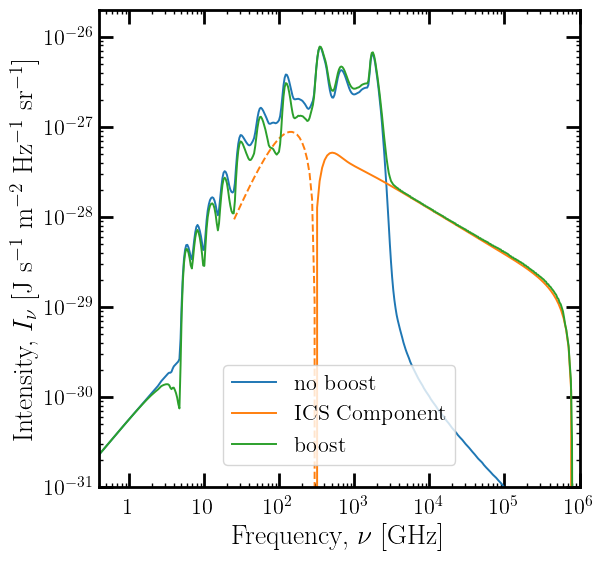

In [2157]:
plt.figure()
ax = plt.gca()
ax.loglog()

# ax.plot(baseline['rs'], baseline['Tm'][:])

# plot_distortion(ax, baseline)
plot_distortion(ax, no_boost, label='no boost', leg=True, first=False)

ICS_component = boost['lowengphot'].copy()
ICS_component._grid_vals *= list(map(int, ICS_component.eng < phys.rydberg))
ICS_component.redshift(1)
ICS_component = {'distortion': ICS_component.sum_specs()}
plot_distortion(ax, ICS_component, label='ICS Component', first=False, leg=True)

plot_distortion(ax, boost, label='boost', leg=True, first=False, ylim=[1e-31,2e-26])

# 2. $f_{exc}$ as a distortion source

In [540]:
%autoreload
DMrun_withf = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=param,
    sigmav=param,
    primary=pri+'_delta',
    start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
    coarsen_factor=coarsen_factor,
    distort=True, recfast_TLA=True,
    fexc_switch = True, reprocess_distortion=False, nmax=nmax
)

  0%|          | 0/400.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:513: RuntimeWarning: overflow encountered in true_divide
  # !!! I should be able to set xHI = 1 - sum(x_full) - xe,
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/low_energy/atomic.py:517: RuntimeWarning: overflow encountered in double_scalars
  
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhis

Text(0.5, 1.0, 'CMB Spectral Distortion due to DM Decay to $e^+e^-$')

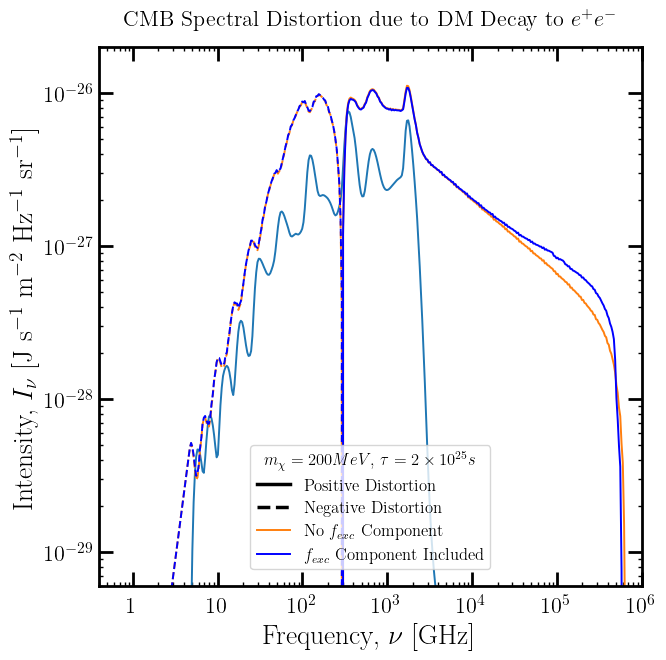

In [549]:
eng = baseline['distortion'].eng

hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
# rs_fac = 1300


plt.figure(figsize=(7, 7))
ax = plt.gca()

plot_distortion(ax, baseline, first=False)
plot_distortion(ax, DMrun, first=True, label=r'No $f_{exc}$ Component', leg=True)
plot_distortion(ax, DMrun_withf, color='blue', first=False,
                label=r'$f_{exc}$ Component Included')


# plt.xticks([1e1,1e2,1e3,1e4,1e5,1e6])

leg = plt.legend(fontsize=12)
leg.set_title(r'$m_\chi = 200 MeV$, $\tau = 2 \times 10^{25}s$')
plt.setp(leg.get_title(),fontsize='12')

plt.title('CMB Spectral Distortion due to DM Decay to $e^+e^-$', fontsize=16)

# 5. Reprocessing of distortion ($\Delta f_\gamma \to $ distortion)

Text(0.5, 1.0, 'CMB Spectral Distortion due to DM Decay to $e^+e^-$')

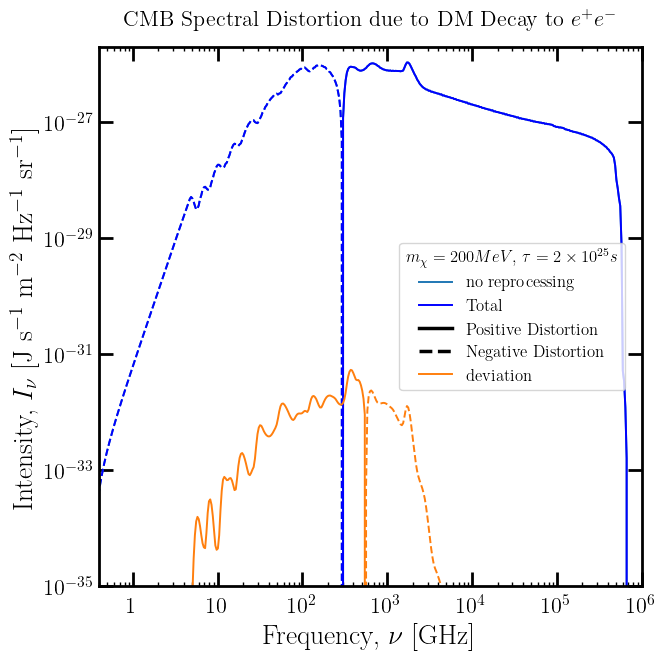

In [561]:
plt.figure(figsize=(7, 7))
ax = plt.gca()

# DH generated data
# plt.plot(tmp.eng/hplanck/1e9, phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
#          color='C1', linewidth=1.4, label='pure ICS', alpha=0.7)
# plt.plot(tmp.eng/hplanck/1e9, -phys.nB * tmp.eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4 * tmp.dNdE,
#          color='C1', linestyle='--', linewidth=1.4, alpha=0.7)

plot_distortion(ax, DMrun_withf, label='no reprocessing',
                first=False, leg=True)
plot_distortion(ax, DM_run_withf_withDf, color='blue', label='Total',
                first=False, leg=True)

plot_distortion(ax, DM_run_withf_withDf, DMrun_withf, 
                label='deviation', leg=True, diff=True,
                color='C1', ylim=[1e-35,2e-26])


leg = plt.legend(fontsize=12)
leg.set_title(r'$m_\chi = 200 MeV$, $\tau = 2 \times 10^{25}s$')
plt.setp(leg.get_title(),fontsize='12')

plt.title('CMB Spectral Distortion due to DM Decay to $e^+e^-$', fontsize=16)

# Anisotropy Constraints

# Scans

In [1983]:
log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = 12.601505994846297

models = ['elec_decay', 'elec_swave', 'phot_decay', 'phot_swave']
data = {model : [] for model in models}

for pri in ['elec', 'phot']:
    for DM_process in ['decay', 'swave']:
        
        model = pri+'_'+DM_process
        print('starting', model)
        
        if pri=='elec':
            if DM_process=='decay':
                mDM_list = 2*(10**log10eng + phys.me)
            else:
                mDM_list = 10**log10eng + phys.me

        elif pri=='phot':
            if DM_process=='decay':
                mDM_list = 2*10**log10eng
            else:
                mDM_list = 10**log10eng
        
        for mDM in tqdm(mDM_list[::10]):
            
            param = param_bound(mDM, DM_process, pri)

            goods = main.evolve(
                DM_process=DM_process, mDM=mDM,
                lifetime=param,
                sigmav = param,
                primary=pri+'_delta',
                start_rs = start_rs, high_rs = 1.555e3, end_rs=end_rs,
                coarsen_factor=coarsen_factor, backreaction=True,
                distort=True, recfast_TLA=True,
                fexc_switch = True, reprocess_distortion=True, nmax=nmax
            )
            
            data[model].append(goods)
            
# pickle.dump(data, open('/Users/gregoryridgway/Desktop/Data/'+
#                        'scan_nmax10_every10th.dat','wb'))

starting elec_decay


/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_50782/1896828737.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for mDM in tqdm(mDM_list[:1]):


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/44.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [2067]:
# datums = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
#                        'scan_nmax10_every10th.dat','rb'))

iter0 = {}
iter1 = {}
iter2 = {}
iter3 = {}
full = {}
for p in ['elec', 'phot']:
    for process in ['decay', 'swave']:
        key = p+'_'+process
        iter0[key] = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                                  'iter0_'+key+'_nmax100_endrs7.dat', 'rb'))
#                        'scan_nmax10_every10th.dat','rb'))
        iter1[key] = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                                  'iter1_'+key+'_nmax100_endrs7.dat', 'rb'))
        iter2[key] = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                                  'iter2_'+key+'_nmax100_endrs5.dat', 'rb'))
        iter3[key] = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                                  'iter3_'+key+'_nmax100_endrs5.dat', 'rb'))
        
#         full[key] = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
#                                   'full_'+key+'_nmax100_endrs5.dat', 'rb'))

iter0['tmp'] = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                          'tmp_iter0_elec_decay_nmax100_endrs7.dat', 'rb'))

iter1['tmp'] = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                          'tmp_iter1_elec_decay_nmax100_endrs7.dat', 'rb'))

In [2071]:
iter0['tmp'] = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                          'tmp_iter0_elec_decay_nmax100_endrs7.dat', 'rb'))

iter1['tmp'] = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
                          'tmp_iter1_elec_decay_nmax100_endrs7.dat', 'rb'))

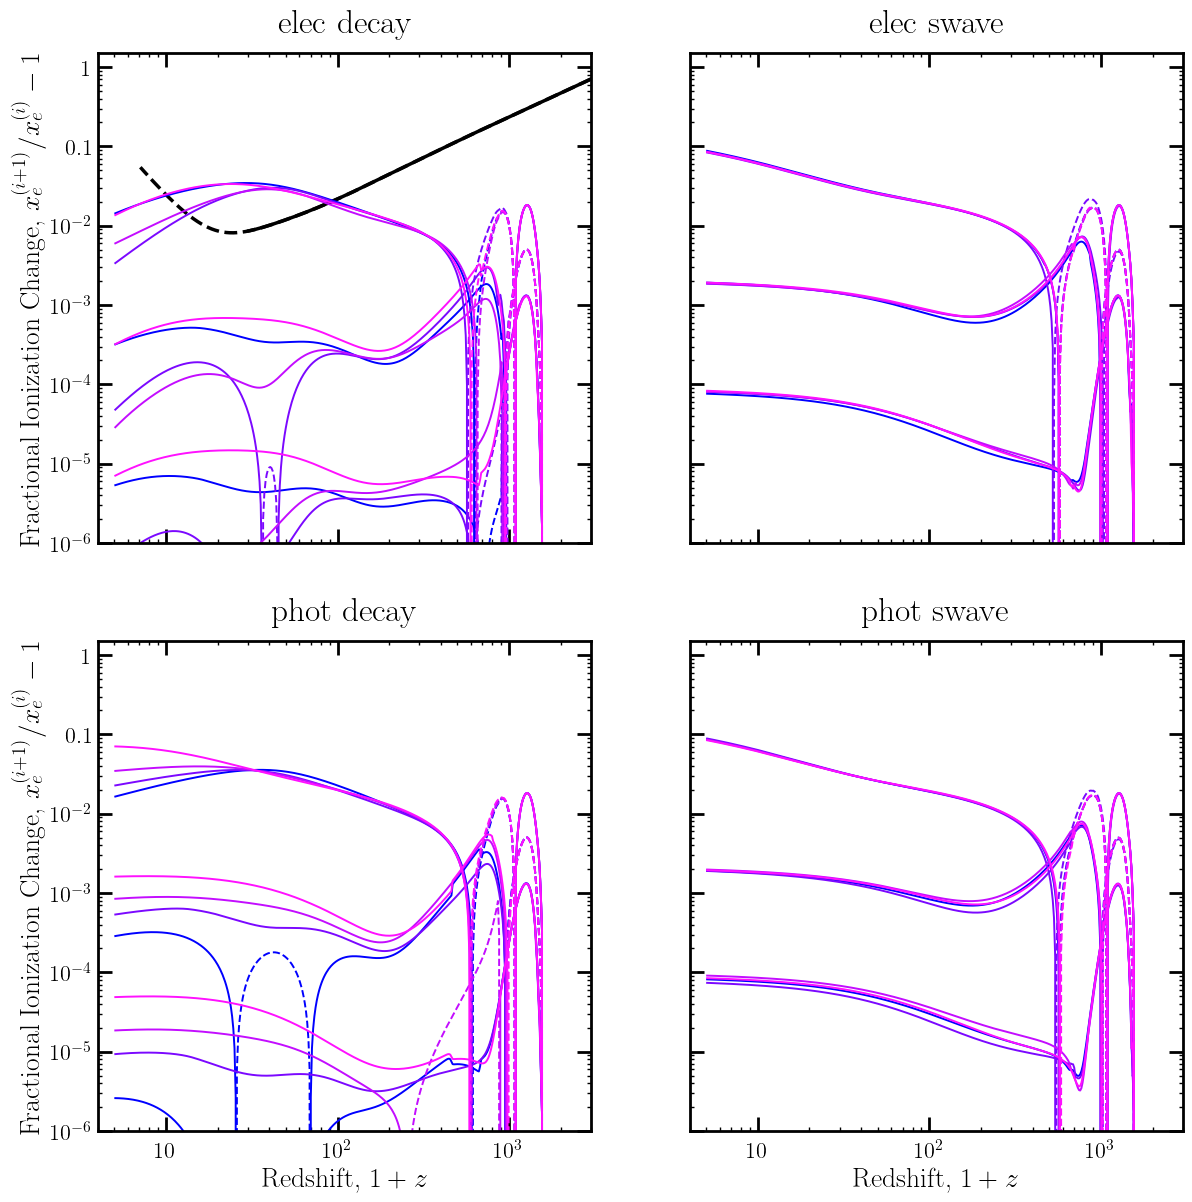

In [1980]:
eng = iter1[key][1][0]['distortion'].eng
rs_vec = iter1[key][1][0]['rs']
hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

fig, axarr = plt.subplots(2,2, figsize=(14, 14), sharex=True, sharey=True)

cs = np.linspace(0,1,len(iter1['elec_decay'][1]))**0.66

for i, pri in enumerate(['elec', 'phot']):
    axarr[i][0].set_ylabel(r'Fractional Ionization Change, $x_e^{(i+1)}/x_e^{(i)}-1$', fontsize=20)
    for j, DM_process in enumerate(['decay', 'swave']):
        axarr[i][j].loglog()
        axarr[i][j].set_xlim([4, 3e3])
        axarr[i][j].set_ylim([1e-6, 1.5])
        
        axarr[1][j].set_xlabel(r'Redshift, $1+z$', fontsize=20)
#         axarr[i][j].plot(x_dict[0]['rs'], 
#                  np.abs(x_dict[0]['x'][:,0]
#                   -x_dict[-1]['x'][:,0])/x_dict[0]['x'][:,0], 'k--')
            
        
        model = pri+'_'+DM_process
        
        axarr[i][j].set_title(pri+' '+DM_process)
        
        for k in np.arange(4):
            axarr[i][j].plot(rs_vec, iter1[model][1][k]['x'][:,0]/iter0[model][1][k]['x'][:,0]-1,
                             color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(rs_vec, 1-iter1[model][1][k]['x'][:,0]/iter0[model][1][k]['x'][:,0],
                             color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
            axarr[i][j].plot(rs_vec, iter2[model][1][k]['x'][:,0]/iter1[model][1][k]['x'][:,0]-1,
                             color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(rs_vec, 1-iter2[model][1][k]['x'][:,0]/iter1[model][1][k]['x'][:,0],
                             color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
            axarr[i][j].plot(rs_vec, iter3[model][1][k]['x'][:,0]/iter2[model][1][k]['x'][:,0]-1,
                             color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(rs_vec, 1-iter3[model][1][k]['x'][:,0]/iter2[model][1][k]['x'][:,0],
                             color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
#             axarr[i][j].plot(rs_vec, full[model][1][k]['x'][::2,0]/iter2[model][1][k]['x'][:,0]-1,
#                              color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
#             axarr[i][j].plot(rs_vec, 1-full[model][1][k]['x'][::2,0]/iter2[model][1][k]['x'][:,0],
#                              color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
#         axarr[i][j].axvline(1.57e3, color='k', linestyle='--')

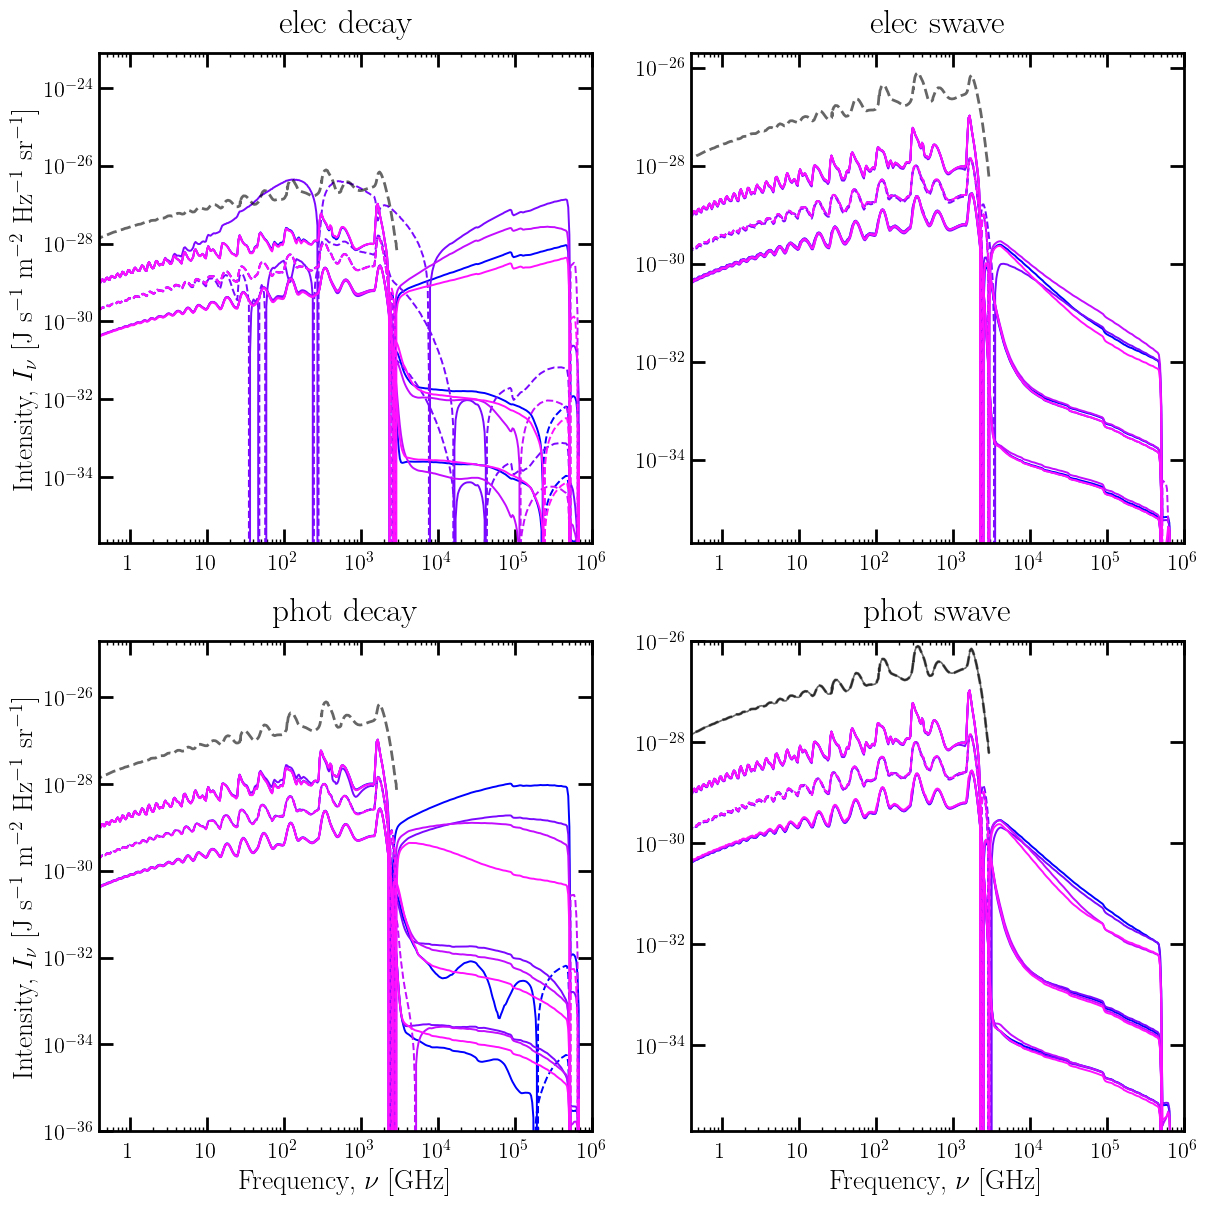

In [272]:
eng = datums[key][1][0]['distortion'].eng
hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

fig, axarr = plt.subplots(2,2, figsize=(14, 14))

cs = np.linspace(0,1,len(iter1['elec_decay'][1]))**0.66

axarr[i][j].plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k',
         linewidth=1.2, label='Chluba+Sunyaev', alpha=0.6)

for i, pri in enumerate(['elec', 'phot']):
    axarr[i][0].set_ylabel(r'Intensity, $I_{\nu}$ '+
                           '[J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
    for j, DM_process in enumerate(['decay', 'swave']):
        axarr[i][j].loglog()
        # plt.xscale('log')
        axarr[i][j].set_xlim([4e-1, 1e6])
        
        if i==1:
            axarr[i][j].set_xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
        
        if DM_process == 'swave':
            if pri == 'elec':
                axarr[i][j].set_ylim([2e-36, 2e-26])
            else:
                axarr[i][j].set_ylim([2e-36, 1e-26])
        else:
            if pri == 'elec':
                axarr[i][j].set_ylim([2e-36, 8e-24])
            else:
                axarr[i][j].set_ylim([1e-36, 2e-25])
        
        model = pri+'_'+DM_process
        axarr[i][j].set_title(pri+' '+DM_process)
        
        for k in np.arange(4):
            axarr[i][j].plot(nu/1e9, convert * (iter1[model][1][k]['distortion'].dNdE
                                               -iter0[model][1][k]['distortion'].dNdE),
                             color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(nu/1e9, -convert * (iter1[model][1][k]['distortion'].dNdE
                                                -iter0[model][1][k]['distortion'].dNdE),
                             color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
            axarr[i][j].plot(nu/1e9, convert * (iter2[model][1][k]['distortion'].dNdE
                                               -iter1[model][1][k]['distortion'].dNdE),
                             color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(nu/1e9, -convert * (iter2[model][1][k]['distortion'].dNdE
                                                -iter1[model][1][k]['distortion'].dNdE),
                             color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
            axarr[i][j].plot(nu/1e9, convert * (iter3[model][1][k]['distortion'].dNdE
                                               -iter2[model][1][k]['distortion'].dNdE),
                             color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(nu/1e9, -convert * (iter3[model][1][k]['distortion'].dNdE
                                                -iter2[model][1][k]['distortion'].dNdE),
                             color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
        axarr[i][j].plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k', linestyle='--',
                 linewidth=2.0, label='Chluba+Sunyaev', alpha=0.6)

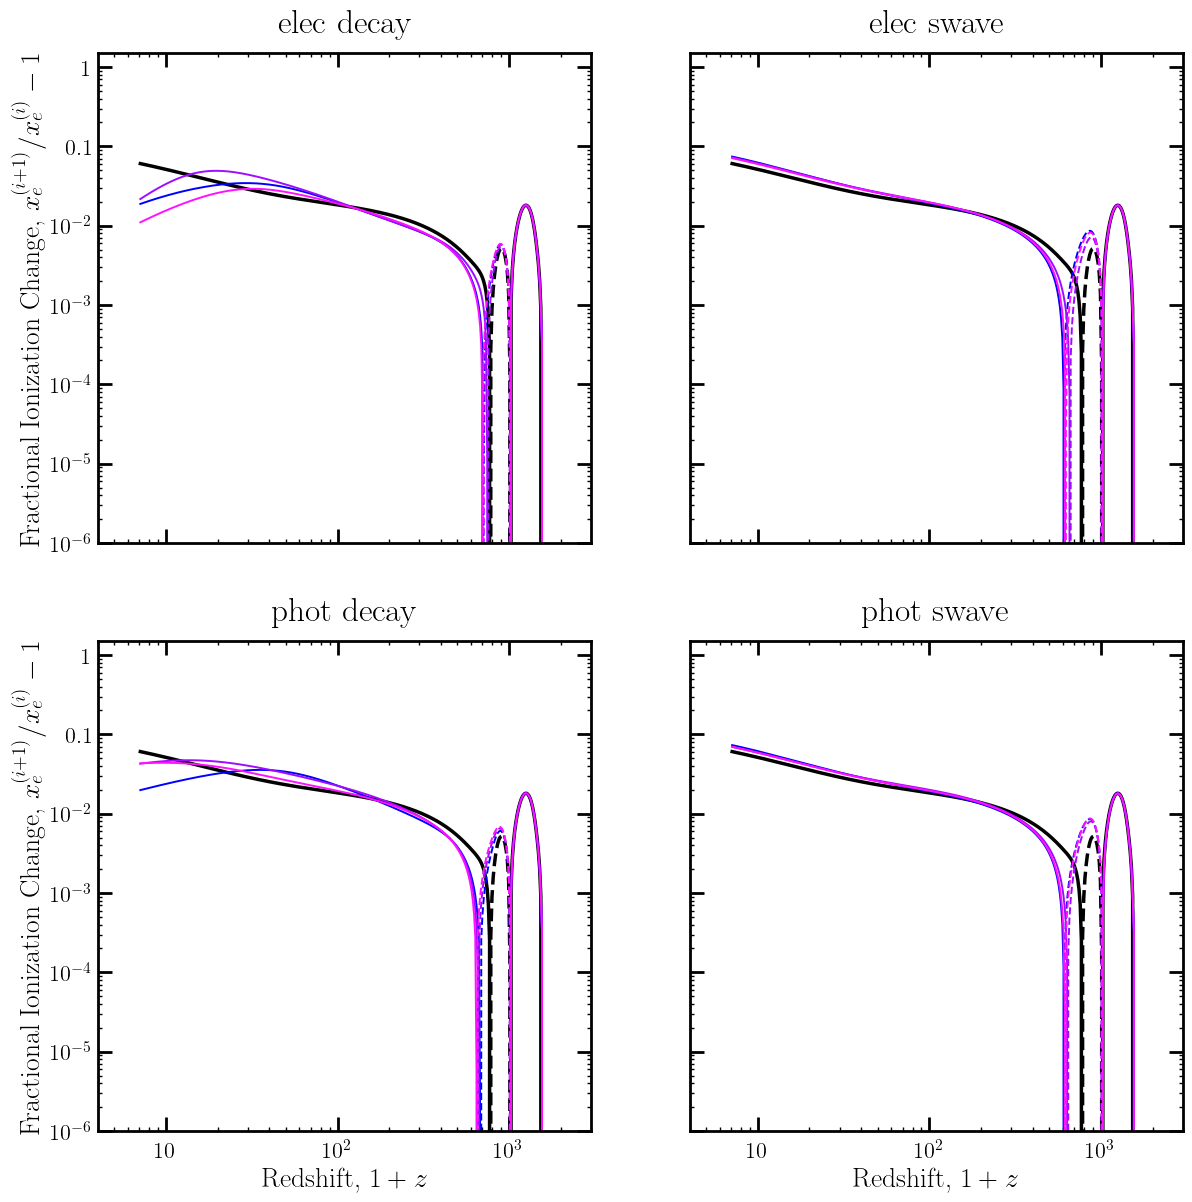

In [2089]:
eng = iter1[key][1][0]['distortion'].eng
rs_vec = iter1[key][1][0]['rs']
hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

fig, axarr = plt.subplots(2,2, figsize=(14, 14), sharex=True, sharey=True)

cs = np.linspace(0,1,len(iter1['elec_decay'][1]))**0.66

for i, pri in enumerate(['elec', 'phot']):
    axarr[i][0].set_ylabel(r'Fractional Ionization Change, $x_e^{(i+1)}/x_e^{(i)}-1$', fontsize=20)
    for j, DM_process in enumerate(['decay', 'swave']):
        axarr[i][j].loglog()
        axarr[i][j].set_xlim([4, 3e3])
        axarr[i][j].set_ylim([1e-6, 1.5])
        
        axarr[1][j].set_xlabel(r'Redshift, $1+z$', fontsize=20)
#         axarr[i][j].plot(x_dict[0]['rs'], 
#                  np.abs(x_dict[0]['x'][:,0]
#                   -x_dict[-1]['x'][:,0])/x_dict[0]['x'][:,0], 'k--')
            
        
        model = pri+'_'+DM_process
        
        axarr[i][j].set_title(pri+' '+DM_process)
        
        axarr[i][j].plot(iterated_withf_withDf['rs'],
                        iterated_withf_withDf['x'][:,0]/DM_run_withf_withDf['x'][:,0]-1,
                         'k')
        axarr[i][j].plot(iterated_withf_withDf['rs'],
                        1-iterated_withf_withDf['x'][:,0]/DM_run_withf_withDf['x'][:,0],
                        'k--')

#         axarr[i][j].plot(rs_vec,
#                         iter1['tmp'][1][0]['x'][:,0]/iter0['tmp'][1][0]['x'][:,0]-1, 'k')
#         axarr[i][j].plot(rs_vec, 
#                          1-iter1['tmp'][1][0]['x'][:,0]/iter0['tmp'][1][0]['x'][:,0], 'k--')
        
        for k in np.arange(3):
            axarr[i][j].plot(rs_vec, iter1[model][1][k]['x'][:,0]/iter0[model][1][k]['x'][:,0]-1,
                             color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(rs_vec, 1-iter1[model][1][k]['x'][:,0]/iter0[model][1][k]['x'][:,0],
                             color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
#             axarr[i][j].plot(rs_vec, iter2[model][1][k]['x'][:,0]/iter1[model][1][k]['x'][:,0]-1,
#                              color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
#             axarr[i][j].plot(rs_vec, 1-iter2[model][1][k]['x'][:,0]/iter1[model][1][k]['x'][:,0],
#                              color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
#             axarr[i][j].plot(rs_vec, iter3[model][1][k]['x'][:,0]/iter2[model][1][k]['x'][:,0]-1,
#                              color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
#             axarr[i][j].plot(rs_vec, 1-iter3[model][1][k]['x'][:,0]/iter2[model][1][k]['x'][:,0],
#                              color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
#             axarr[i][j].plot(rs_vec, full[model][1][k]['x'][::2,0]/iter2[model][1][k]['x'][:,0]-1,
#                              color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
#             axarr[i][j].plot(rs_vec, 1-full[model][1][k]['x'][::2,0]/iter2[model][1][k]['x'][:,0],
#                              color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
#         axarr[i][j].axvline(1.57e3, color='k', linestyle='--')

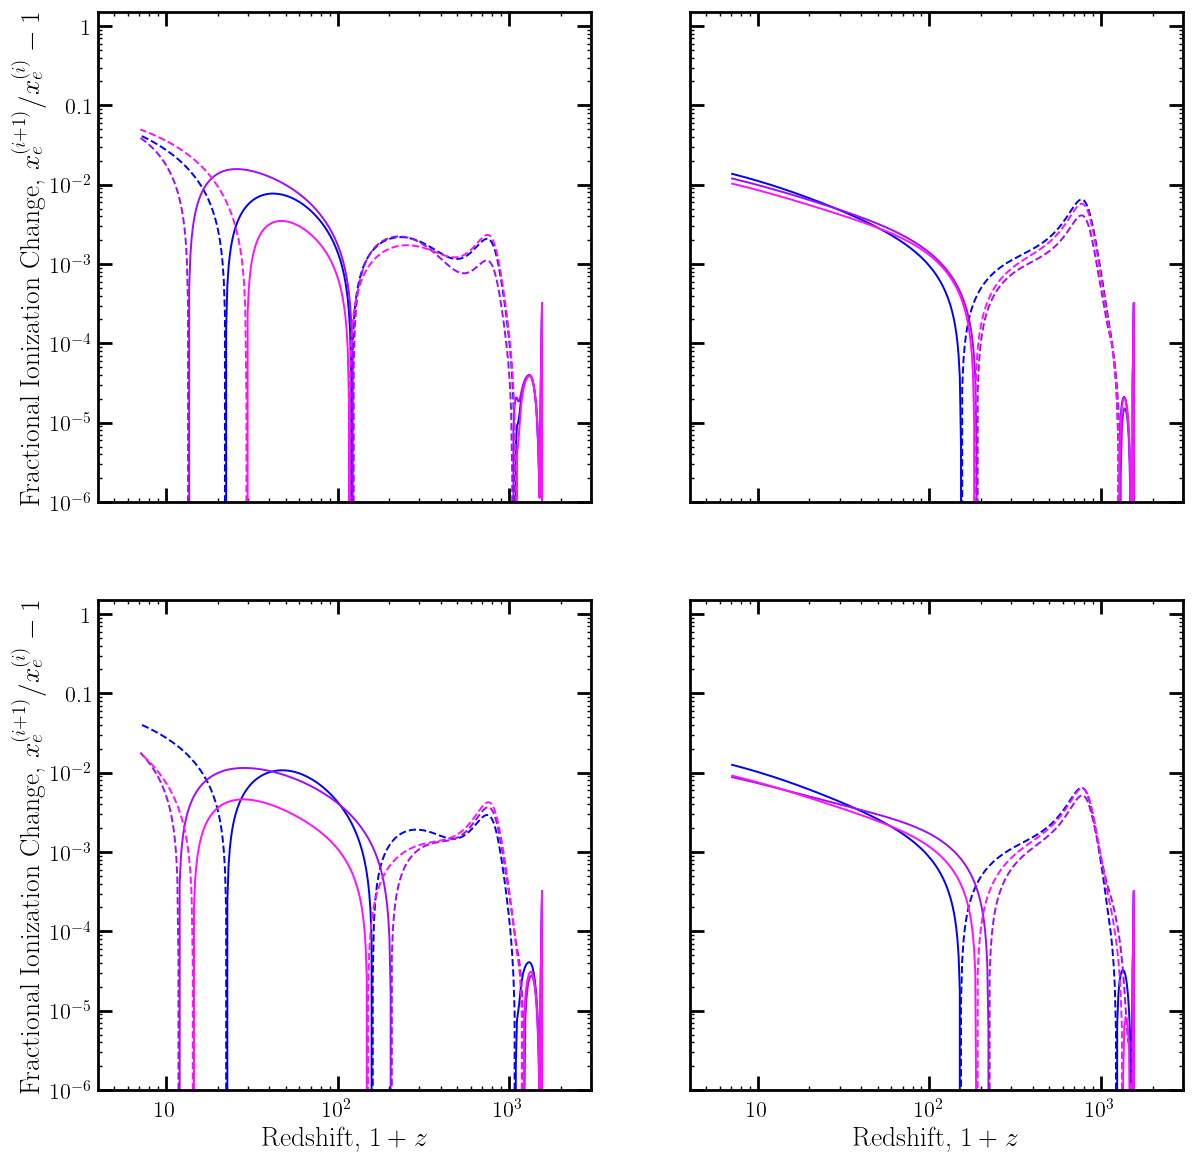

In [2090]:
eng = iter1[key][1][0]['distortion'].eng
rs_vec = iter1[key][1][0]['rs']
hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

fig, axarr = plt.subplots(2,2, figsize=(14, 14), sharex=True, sharey=True)

cs = np.linspace(0,1,len(iter1['elec_decay'][1]))**0.66

for i, pri in enumerate(['elec', 'phot']):
    axarr[i][0].set_ylabel(r'Fractional Ionization Change, $x_e^{(i+1)}/x_e^{(i)}-1$', fontsize=20)
    for j, DM_process in enumerate(['decay', 'swave']):
        axarr[i][j].loglog()
        axarr[i][j].set_xlim([4, 3e3])
        axarr[i][j].set_ylim([1e-6, 1.5])
        
        axarr[1][j].set_xlabel(r'Redshift, $1+z$', fontsize=20)
#         axarr[i][j].plot(x_dict[0]['rs'], 
#                  np.abs(x_dict[0]['x'][:,0]
#                   -x_dict[-1]['x'][:,0])/x_dict[0]['x'][:,0], 'k--')
            
        
        model = pri+'_'+DM_process
        
        for k in np.arange(3):
            axarr[i][j].plot(rs_vec, iter1[model][1][k]['x'][:,0]/iter0[model][1][k]['x'][:,0]-iterated_withf_withDf['x'][:,0]/DM_run_withf_withDf['x'][:,0],
                             color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(rs_vec, iterated_withf_withDf['x'][:,0]/DM_run_withf_withDf['x'][:,0]-iter1[model][1][k]['x'][:,0]/iter0[model][1][k]['x'][:,0],
                             color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)

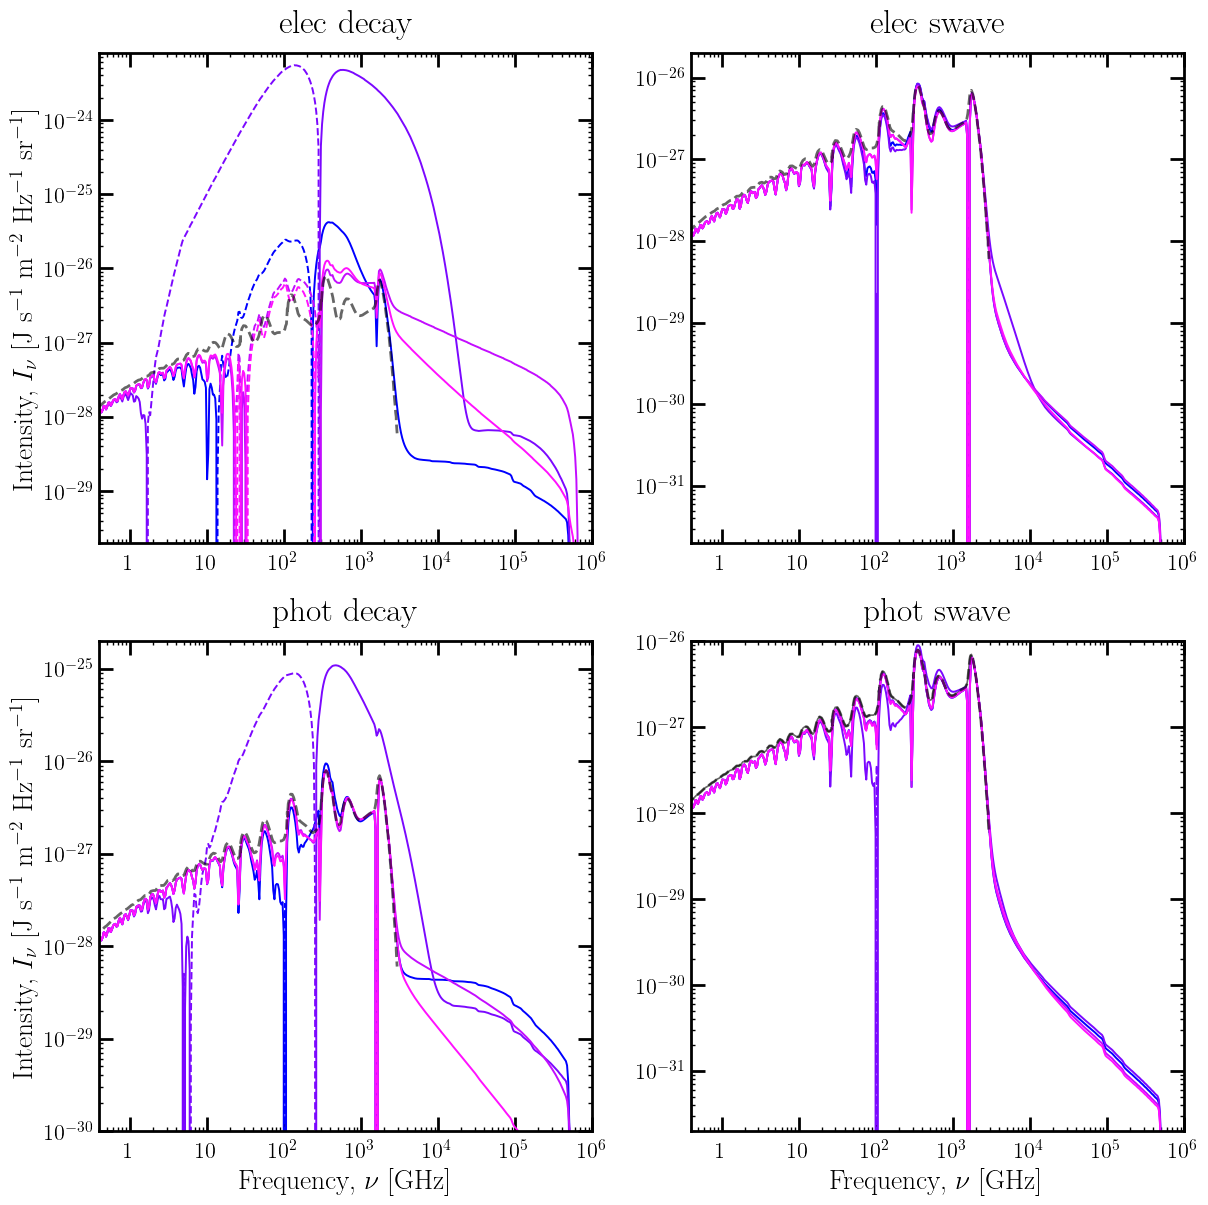

In [1655]:
eng = datums[key][1][0]['distortion'].eng
hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

fig, axarr = plt.subplots(2,2, figsize=(14, 14))

cs = np.linspace(0,1,len(iter1['elec_decay'][1]))**0.66

axarr[i][j].plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k',
         linewidth=1.2, label='Chluba+Sunyaev', alpha=0.6)

for i, pri in enumerate(['elec', 'phot']):
    axarr[i][0].set_ylabel(r'Intensity, $I_{\nu}$ '+
                           '[J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
    for j, DM_process in enumerate(['decay', 'swave']):
        axarr[i][j].loglog()
        # plt.xscale('log')
        axarr[i][j].set_xlim([4e-1, 1e6])
        
        if i==1:
            axarr[i][j].set_xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
        
        if DM_process == 'swave':
            if pri == 'elec':
                axarr[i][j].set_ylim([2e-32, 2e-26])
            else:
                axarr[i][j].set_ylim([2e-32, 1e-26])
        else:
            if pri == 'elec':
                axarr[i][j].set_ylim([2e-30, 8e-24])
            else:
                axarr[i][j].set_ylim([1e-30, 2e-25])
        
        model = pri+'_'+DM_process
        axarr[i][j].set_title(pri+' '+DM_process)
        
        for k in np.arange(4):
#             axarr[i][j].plot(nu/1e9, convert * (iter3[model][1][k]['distortion'].dNdE
#                                                -0*iter0[model][1][k]['distortion'].dNdE),
#                              color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
#             axarr[i][j].plot(nu/1e9, -convert * (iter3[model][1][k]['distortion'].dNdE
#                                                 -0*iter0[model][1][k]['distortion'].dNdE),
#                              color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
                
            axarr[i][j].plot(nu/1e9, convert * full[model][1][k]['distortion'].dNdE,
                            color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
            axarr[i][j].plot(nu/1e9, -convert * full[model][1][k]['distortion'].dNdE,
                            color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
    
#             axarr[i][j].plot(nu/1e9, convert * (full[model][1][k]['distortion'].dNdE
#                                                -iter3[model][1][k]['distortion'].dNdE),
#                              color=(cs[k],cs[k]/15,1), linestyle='solid', linewidth=1.4)
#             axarr[i][j].plot(nu/1e9, -convert * (full[model][1][k]['distortion'].dNdE
#                                                 -iter3[model][1][k]['distortion'].dNdE),
#                              color=(cs[k],cs[k]/15,1), linestyle='--', linewidth=1.4)
            
        axarr[i][j].plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k', linestyle='--',
                 linewidth=2.0, label='Chluba+Sunyaev', alpha=0.6)
        
# plt.savefig(fig_dir+'distortion_grid.pdf')

TODO
- check the baseline scenario (no DM injection). See how much comes from difference between BB and truth, but also numerical precision (n=100 approx)
- one second iteration to show that the iteration procedure works
- Include reionization, make sure it's consistent with Planck's 2sigma region, see if dominant contribution comes from latest times (that we're not keeping track of)
- understand where the features come from

In [198]:
# tmp = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
#                             'iter0_elec_swave_nmax10_endrs5.dat','rb'))
# baseline = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
#                             'baseline_elec_decay_nmax20_endrs900.dat','rb'))

# goods = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
#                             'iter0_phot_decay_nmax10_endrs5.dat','rb'))
# sum(np.isnan(baseline[1][0]['distortions'].toteng()))
# input_dir = '/Users/gregoryridgway/Dropbox (MIT)/DarkHistory_V2/data/'
# input_dir = '/Users/gregoryridgway/Desktop/Data/'
# data = pickle.load(open(input_dir+
#                         'iter0_elec_decay_nmax100_endrs5_03_22.dat','rb'))  #_03_22

In [1054]:
nmax=100
run100_0 = main.evolve(
    DM_process='decay', mDM=10**6.01,
    lifetime=2.7e24*1e20,
    primary='elec_delta',
    start_rs = 2e3, high_rs = 1.555e3, end_rs=700,
    coarsen_factor=cf, backreaction=True,
    distort=True,
    nmax=nmax,
    recfast_TLA=True,
    # MLA_funcs=MLA_funcs, 
    fexc_switch = True, reprocess_distortion=False,
    cross_check=False
)

  0%|          | 0/66.0 [00:00<?, ?it/s]

In [1282]:
%autoreload
nmax=20
run100_2 = main.evolve(
    DM_process='decay', mDM=10**6.01,
    lifetime=2.7e24*1e20,
    primary='elec_delta',
    start_rs = 2e3, high_rs = 1.555e3, end_rs=700,
    coarsen_factor=cf, backreaction=True,
    distort=True,
    nmax=nmax,
    recfast_TLA=True,
    # MLA_funcs=MLA_funcs, 
    fexc_switch = True, reprocess_distortion=True,
    cross_check=False
)

  0%|          | 0/66.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.00000000e+00 9.94470821e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.70873631e-08 1.22177628e-08
 2.27077087e-08 3.44675479e-08]
[0.00000000e+00 1.33415246e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.46865442e-08 2.41291309e-08
 4.01320171e-08 3.52804055e-08]
[0.00000000e+00 1.90507713e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.70037208e-08 3.42312992e-08
 5.55088187e-08 4.69235515e-08]
[0.00000000e+00 3.18596417e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.28816370e-08 4.85880139e-08
 6.96562303e-08 7.15306525e-08]
[0.00000000e+00 5.11021270e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.06311719e-07 6.93847720e-08
 1.04599602e-07 9.73622362e-08]
[0.00000000e+00 8.31829809e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.59969742e-07 9.84184051e-08
 1.49962005e-07 1.39817926e-07]
[0.00000000e

KeyboardInterrupt: 

## Iterations at $n_{max}=100$

In [873]:
for i in np.arange(5):
    mDM = iter1[100][0][i]
    run = iter1[100][1][i]
    param = param_bound(mDM, DM_process, pri)

#     beta_func = interp1d(np.log(run['rs']), np.log(run['MLA'][1][1:]))
#     def beta_MLA(rs):
#         return np.exp(beta_func(np.log(rs)))

#     MLA_funcs = np.array([
#         interp1d(run['rs'], run['MLA'][0][1:]),
#         beta_MLA
#     ])

    f_raw = {key: interp1d(run['rs'], run['f'][key],
                           bounds_error=False, fill_value = (0,0))
             for key in run['f'].keys()}

    def f_H_ion(rs, xHI, xHeI, xHeII):
        return f_raw['H ion'](rs)
    def f_heat(rs, xHI, xHeI, xHeII):
        return f_raw['heat'](rs)
    def f_H_exc(rs, xHI, xHeI, xHeII):
        return f_raw['Lya'](rs)

    def rate_func_eng(rs):
        return phys.inj_rate(DM_process, rs, mDM=mDM, lifetime=param, sigmav=param)

#     rs_vec = np.exp(np.arange(np.log(3e3),np.log(5),-.001*16))

    out = tla.get_history(
        rs_list, high_rs=np.inf,
        f_H_ion=f_H_ion, f_H_exc=f_H_exc, f_heating=f_heat,
        injection_rate=rate_func_eng,
        recfast_TLA=True,
#         alpha_MLA=MLA_funcs[0], beta_MLA=MLA_funcs[1],
        mxstep=10000, rtol=1e-8
    )
    iter0.append(out[:,1])

In [871]:
iter0, iter1, iter2 = [], {}, {}

In [917]:
pri = 'elec'
DM_process = 'decay'

for nmax in [10,100]:
    iter1[nmax] = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
        'iter1_'+pri+'_'+DM_process+'_nmax'+str(nmax)+'_endrs5.dat','rb'))

    iter2[nmax] = pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
        'iter2_'+pri+'_'+DM_process+'_nmax'+str(nmax)+'_endrs5.dat','rb'))
    
rs_list = iter1[100][1][i]['rs']

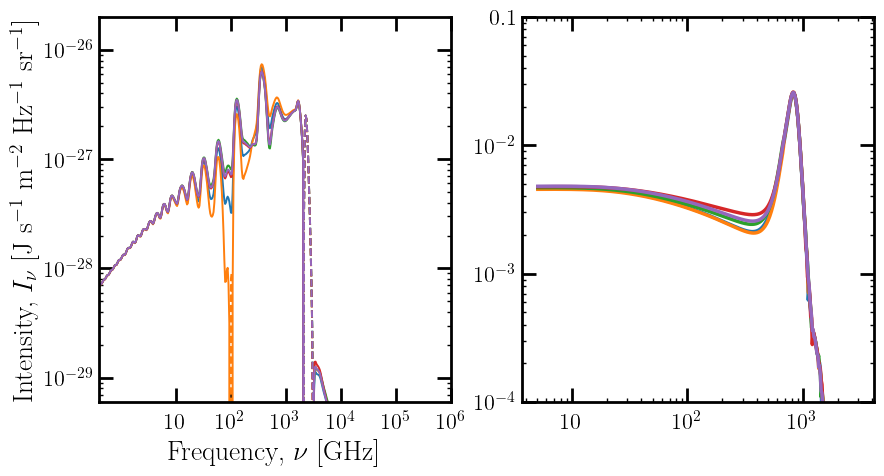

In [913]:
f, axarr = plt.subplots(1,2, figsize=(10,5))
axarr[0].loglog()
axarr[1].loglog()

axarr[1].set_ylim([1e-4,.1])

# i=0
for i in np.arange(5):
# axarr[0].plot(rs_list, iter0[i])
# axarr[0].plot(rs_list, iter1[100][1][i]['x'][:,0], ':')
# axarr[0].plot(rs_list, iter2[100][1][i]['x'][:,0], '--')
# axarr[0].plot(rs_list, phys.xHII_std(rs_list))

# axarr[0].plot(rs_list, np.abs(iter1[100][1][i]['x'][:,0]/iter0[i]-1))
# axarr[0].plot(rs_list, np.abs(iter2[100][1][i]['x'][:,0]/iter1[100][1][i]['x'][:,0]-1))
#     axarr[0].plot(iter1[10][1][i]['rs'], 
#                   np.abs(iter1[10][1][i]['x'][:,0]/iter0[10][1][i]['x'][:,0]-1),
#                  color='C'+str(i), linewidth=1.2, alpha=0.8, linestyle='--')

#     axarr[0].plot(rs_list, 
#                   np.abs(iter1[100][1][i]['x'][:,0]/iter0[i]-1),
#                  color='C'+str(i), linestyle=':')
    
    plot_distortion(axarr[0], iter1[100][1][i], diff=False)
#     plot_distortion(axarr[1], iter2[100][1][i], diff=False)
    
    axarr[1].plot(rs_vec, 
                  np.abs(iter2[100][1][i]['x'][:,0]/iter1[100][1][i]['x'][:,0]-1),
                 color='C'+str(i))

In [1811]:
iter_newRates = []
# nmax=10

for i in range(5):
    iter_newRates.append(pickle.load(open('/Users/gregoryridgway/Desktop/Data/'+
        'iter'+str(i)+'_'+pri+'_'+DM_process+'_nmax10_endrs5.dat','rb')))

1
2
3


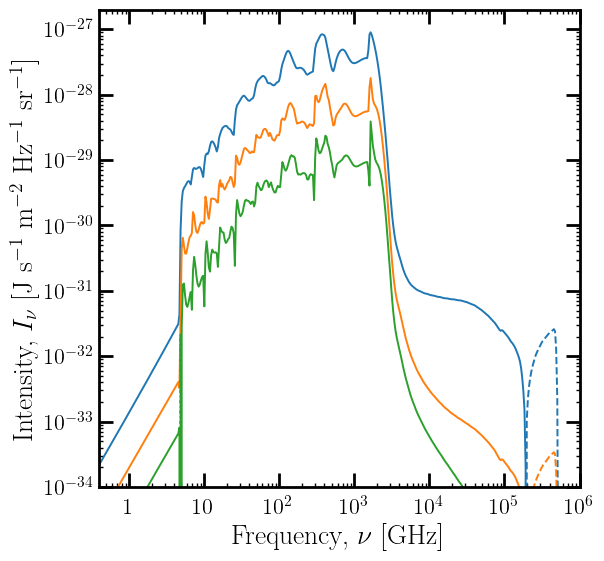

In [1812]:
plt.figure()
ax = plt.gca()
m_ind = 0

for i in range(1,4):
    print(i)
    plot_distortion(ax, iter_newRates[i+1][1][m_ind], iter_newRates[i][1][m_ind],
                    diff=True, ylim=[1e-34,2e-27])
#     plot_distortion(ax, iter_newRates[0][1][1], color='C1')
#     plot_distortion(ax, iter_newRates[0][1][2], color='C2')
#     plot_distortion(ax, iter_newRates[0][1][3], color='C3')
    
# plt.plot(n10_data[:,0], n10_data[:,1], color='k',
#          linewidth=1.2, label='Chluba+Sunyaev', alpha=0.6)

## 21cm Results

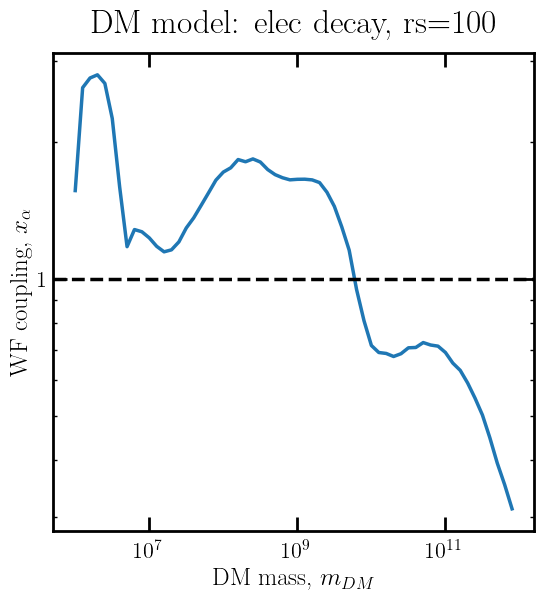

In [1615]:
rs=100
DH_switch=True

if not DH_switch:
    chi_alpha = 1/6.
    xi = 1e-24  # s^-1
    dE_dVdt_dep = chi_alpha * xi * phys.mp * phys.nB * rs**3
    
else:
    pri = 'elec'
    DM_process = 'decay'
    if pri == 'elec':
        log10_mstart = np.log10(2*phys.me + 1e3)
    else:
        log10_mstart = 4
    mDM = 10**np.arange(log10_mstart, 12, .1)
    param = param_bound(mDM, DM_process, pri)
    dE_dVdt_inj = phys.inj_rate(DM_process, rs, mDM=mDM, lifetime=param, sigmav=param)
    dE_dVdt_dep = phys.f_std(mDM, rs, pri, DM_process, False, 'exc') * dE_dVdt_inj

ans = 1.81e11 / rs * phys.c/(4*np.pi) /(
        hplanck * phys.lya_freq**2) / phys.hubble(rs) * dE_dVdt_dep
    
if not DH_switch:
    print(rs, ans)
else:
    plt.figure()
    plt.loglog()
    plt.plot(mDM, ans)
    plt.xlabel(r'DM mass, $m_{DM}$')
    plt.ylabel(r'WF coupling, $x_\alpha$')
    plt.title('DM model: '+pri+' '+DM_process+', rs='+str(rs))
    
    plt.axhline(1, color='k', linestyle='--')